This notebook covers the process of evaluating different normalization approaches and similarity metrics in order to maximize performance in the baseline solution

In [1]:
import pickle
import collections
import matplotlib.pyplot as plt
import faiss
import numpy as np
import itertools
import statistics
import matplotlib.cm as cm
import time
import os

In [2]:
# read in embeddings and cluster label info
with open('embedding64.pickle', 'rb') as fp:
    embedding64 = pickle.load(fp)
with open('label_info.pickle', 'rb') as fp:
    label_info = pickle.load(fp)

print(embedding64.keys())
print(label_info.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])
dict_keys(['batch id', 'age', 'total_cg', 'average_cg_rate', 'total_ch', 'average_ch_rate', 'hic_counts', 'cell_name_higashi', 'major', 'minor', 'cluster label', 'cluster label minor'])


In [3]:
# create helpful dicts for the cluster labels
# also look at n counts for the clusters
major_labels = list(set(label_info['cluster label']))
minor_labels = list(set(label_info['cluster label minor']))

major = dict(zip(major_labels,[[] for item in major_labels]))
minor = dict(zip(minor_labels,[[] for item in minor_labels]))

for j in range(len(label_info['cluster label'])):
    maj = label_info['cluster label'][j]
    min = label_info['cluster label minor'][j]

    if maj in major.keys():
        major[maj].append(j)
    if min in minor.keys():
        minor[min].append(j)

print("MAJOR CLUSTERS")
for key in major.keys():
    s = "    " + key + ": " + str(len(major[key]))
    print(s)
    
print("MINOR CLUSTERS")
for key in minor.keys():
    s = "    " + key + ": " + str(len(minor[key]))
    print(s)

MAJOR CLUSTERS
    MG: 422
    L2/3: 551
    Endo: 205
    L4: 131
    Vip: 171
    L6: 86
    Astro: 449
    Ndnf: 144
    OPC: 203
    MP: 100
    Pvalb: 134
    ODC: 1245
    L5: 180
    Sst: 217
MINOR CLUSTERS
    Astro-1: 449
    L5-1: 48
    L2/3-1: 137
    Endo-1: 51
    L6-1: 67
    Sst-2: 107
    L5-2: 74
    MP-1: 100
    Endo-2: 69
    L2/3-2: 137
    Vip-2: 126
    Pvalb-2: 21
    Endo-3: 85
    ODC-2: 435
    L5-3: 58
    ODC-1: 810
    L4-1: 131
    L6-2: 19
    Vip-1: 45
    Sst-1: 50
    MG-1: 422
    L2/3-3: 127
    Ndnf-2: 63
    Sst-3: 60
    Pvalb-1: 113
    OPC-1: 203
    Ndnf-1: 59
    L2/3-4: 150
    Ndnf-3: 22


In [4]:
# function to get memory footprint for index
# source: https://www.pinecone.io/learn/series/faiss/product-quantization/
def get_memory(index):
    faiss.write_index(index,'./temp.index')
    file_size = os.path.getsize('./temp.index')
    os.remove('./temp.index')
    return file_size

In [5]:
# function to create index and return baseline search results
def baseline_index(input, input_index):
    database = input
    d = 64
    k = len(database)
    index=input_index
    print(index.is_trained)
    index.add(database)   
    print(index.ntotal)
    start = time.time()
    D, I = index.search(database, k)
    end = time.time()
    memory = get_memory(index)
    print("Total search time: %.6f seconds" % (end-start))
    print("Index size: %s bytes" % memory)
    return I
    

In [6]:
# function to calculate recall based on search results
def get_recall(search_result):
    recall_maj = []
    recall_min = []

    for i in range(4238):
        true_maj_cluster = label_info['cluster label'][i]
        true_min_cluster = label_info['cluster label minor'][i]
    
        true_maj_size = len(major[true_maj_cluster])
        true_min_size = len(minor[true_min_cluster])
    
        recall_maj.append(len(set(major[true_maj_cluster]).intersection(search_result[i,0:true_maj_size]))/true_maj_size)
        recall_min.append(len(set(minor[true_min_cluster]).intersection(search_result[i,0:true_min_size]))/true_min_size)

    return recall_maj, recall_min

In [7]:
# function to create subplots in recall figure (major and minor)
def recall_subplot(ax, labels, true_clusters, recall, embedname):
    y_lower = 10
    recall_avg = statistics.mean(recall)    
    print("Average recall: %.5f" % recall_avg)
    
    for i in range(len(labels)):           
        # select cells in cluster
        cluster_filter = [element==labels[i] for element in true_clusters]
        ith_cluster_recall_values = list(itertools.compress(recall,cluster_filter))
        ith_cluster_recall_values.sort()
        size_cluster_i = len(ith_cluster_recall_values)
        y_upper = y_lower + size_cluster_i

        # pick color
        color = cm.nipy_spectral(float(i) / len(labels))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_recall_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7,)

        # label the cluster
        ax.text(-0.095, y_lower + 0.5 * size_cluster_i, str(labels[i]))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(embedname)
        ax.set_xlabel("Recall: True Positives / (True Positives + False Negatives)")
        ax.set_ylabel("Cluster label")

        # The vertical line for average recall score of all the values
        ax.axvline(x=recall_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [8]:
# create recall figure for test embedding-index combination
def plot_recall(search_result, title, filename):
    # get recall
    recall_major, recall_minor = get_recall(search_result)
     
    # set up plot for figure 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20, 10)
    ax1.set_xlim([0, 1])
    

    recall_subplot(ax1, major_labels, label_info['cluster label'], recall_major, str(title+" (major clusters)"))
    recall_subplot(ax2, minor_labels, label_info['cluster label minor'], recall_minor, str(title+" (minor clusters)"))  

    fig.savefig(filename)
    plt.show()

True
4238
Total search time: 1.952934 seconds
Index size: 1084973 bytes
Average recall: 0.77144
Average recall: 0.60616


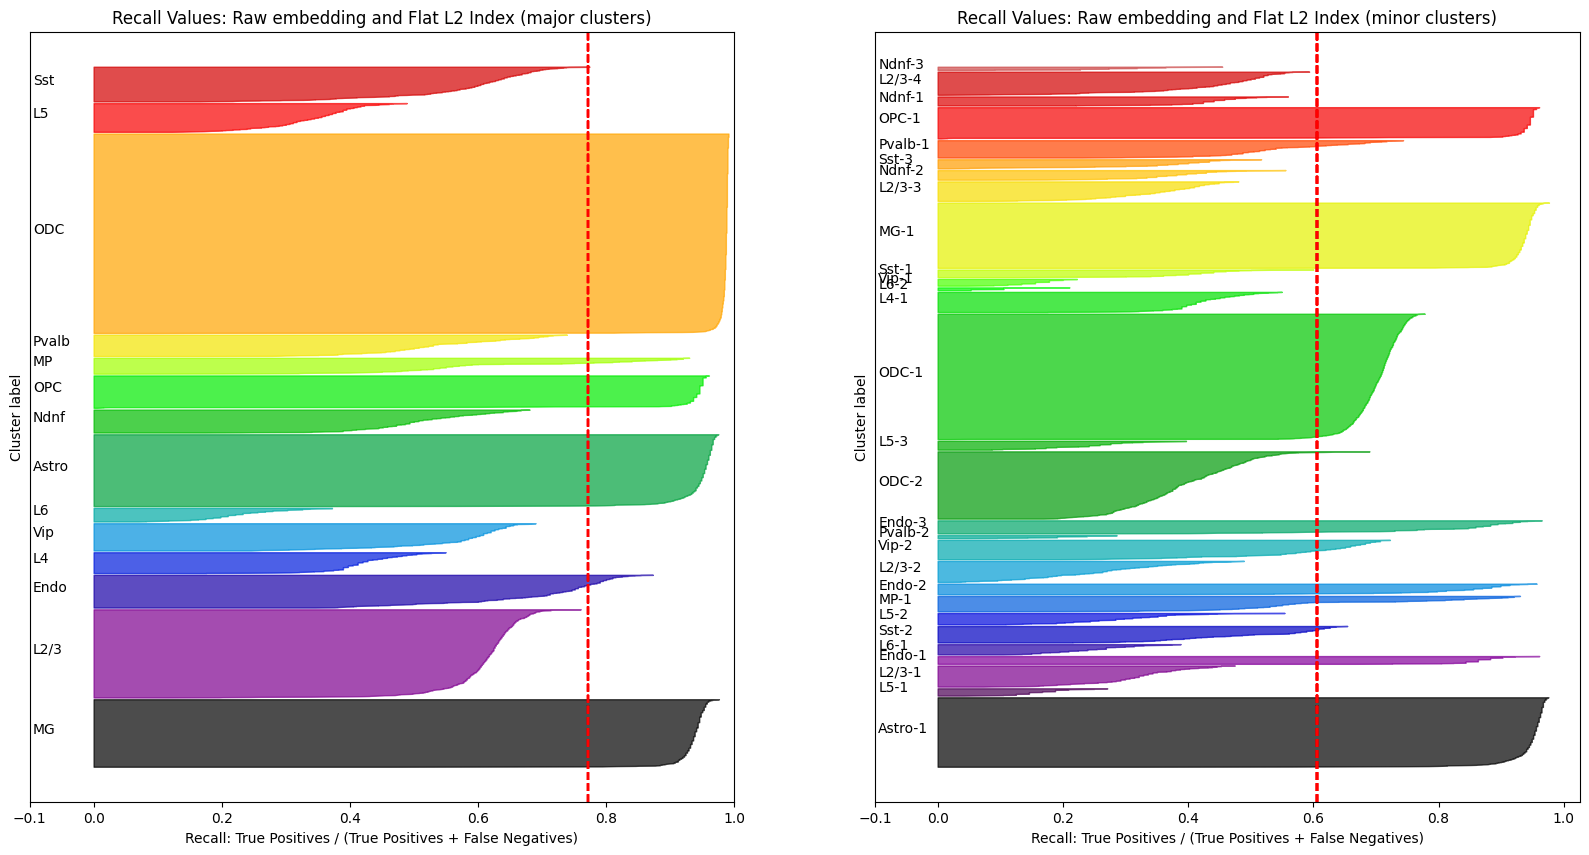

True
4238
Total search time: 1.754207 seconds
Index size: 1084973 bytes
Average recall: 0.79247
Average recall: 0.59638


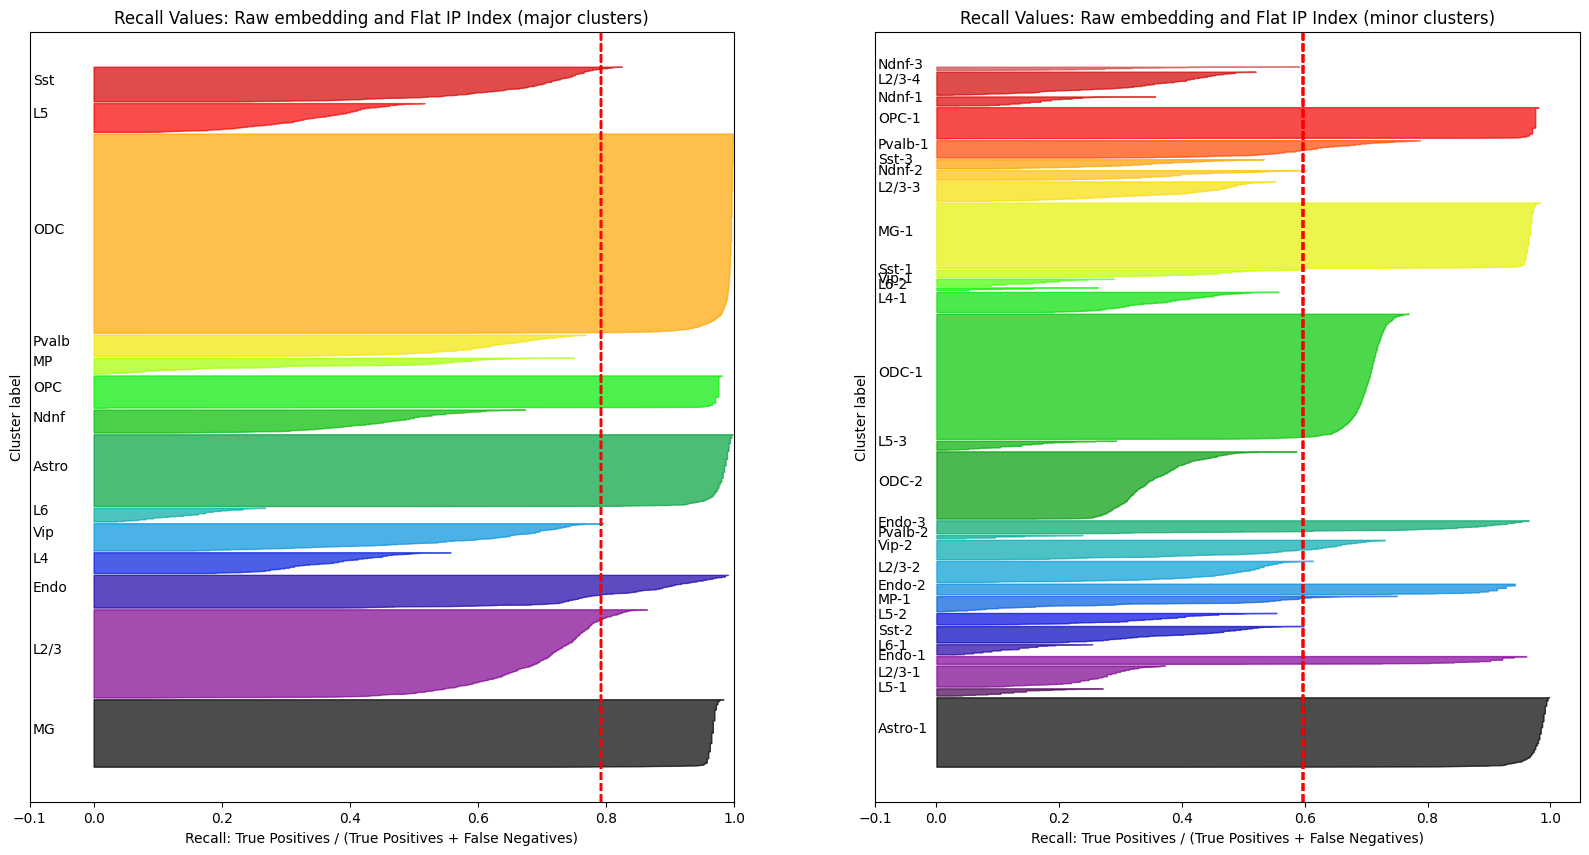

In [9]:
### RAW EMBEDDING
db = np.array(embedding64["embed_raw"])

# L2 FLAT INDEX
# create index and search
res3 = baseline_index(db, faiss.IndexFlatL2(64))
# plot recall values
plot_recall(res3, "Recall Values: Raw embedding and Flat L2 Index", "Baseline_raw_L2.png")

# IP FLAT INDEX
# create index and search
res4 = baseline_index(db, faiss.IndexFlatIP(64))
# plot recall values
plot_recall(res4, "Recall Values: Raw embedding and Flat IP Index", "Baseline_raw_IP.png")

True
4238
Total search time: 1.800537 seconds
Index size: 1084973 bytes
Average recall: 0.79842
Average recall: 0.62159


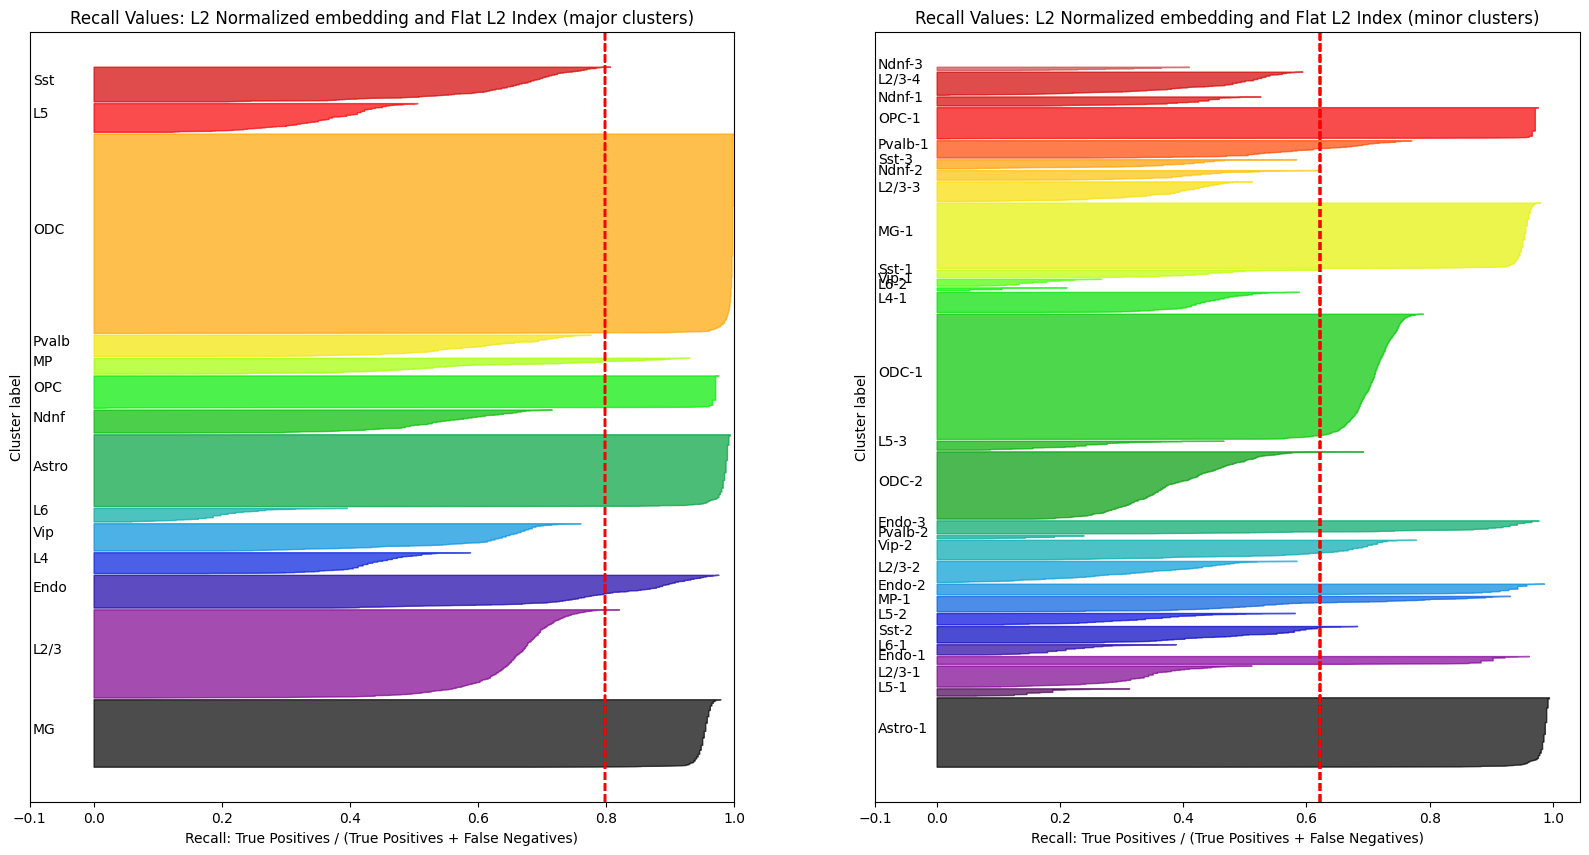

True
4238
Total search time: 2.175902 seconds
Index size: 1084973 bytes
Average recall: 0.79842
Average recall: 0.62159


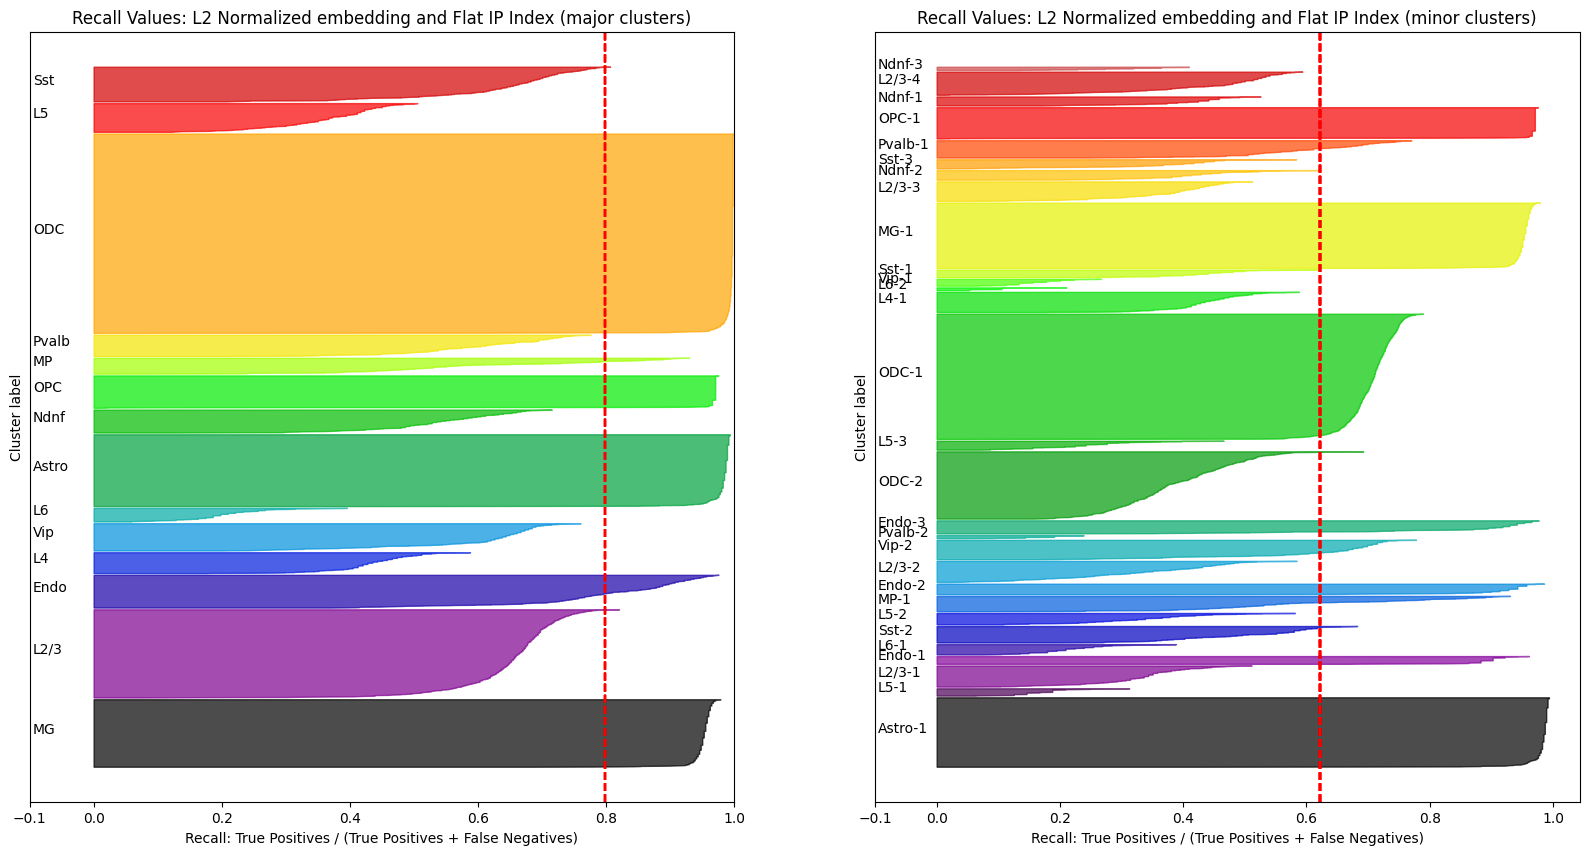

In [10]:
### L2 NORMALIZED EMBEDDING
db = np.array(embedding64["embed_l2_norm"])

# L2 FLAT INDEX
# create index and search
res1 = baseline_index(db, faiss.IndexFlatL2(64))
# plot recall values
plot_recall(res1, "Recall Values: L2 Normalized embedding and Flat L2 Index", "Baseline_L2Norm_L2.png")

# IP FLAT INDEX
# create index and search
res2 = baseline_index(db, faiss.IndexFlatIP(64))
# plot recall values
plot_recall(res2, "Recall Values: L2 Normalized embedding and Flat IP Index", "Baseline_L2Norm_IP.png")

True
4238
Total search time: 2.472978 seconds
Index size: 1084973 bytes
Average recall: 0.77039
Average recall: 0.60266


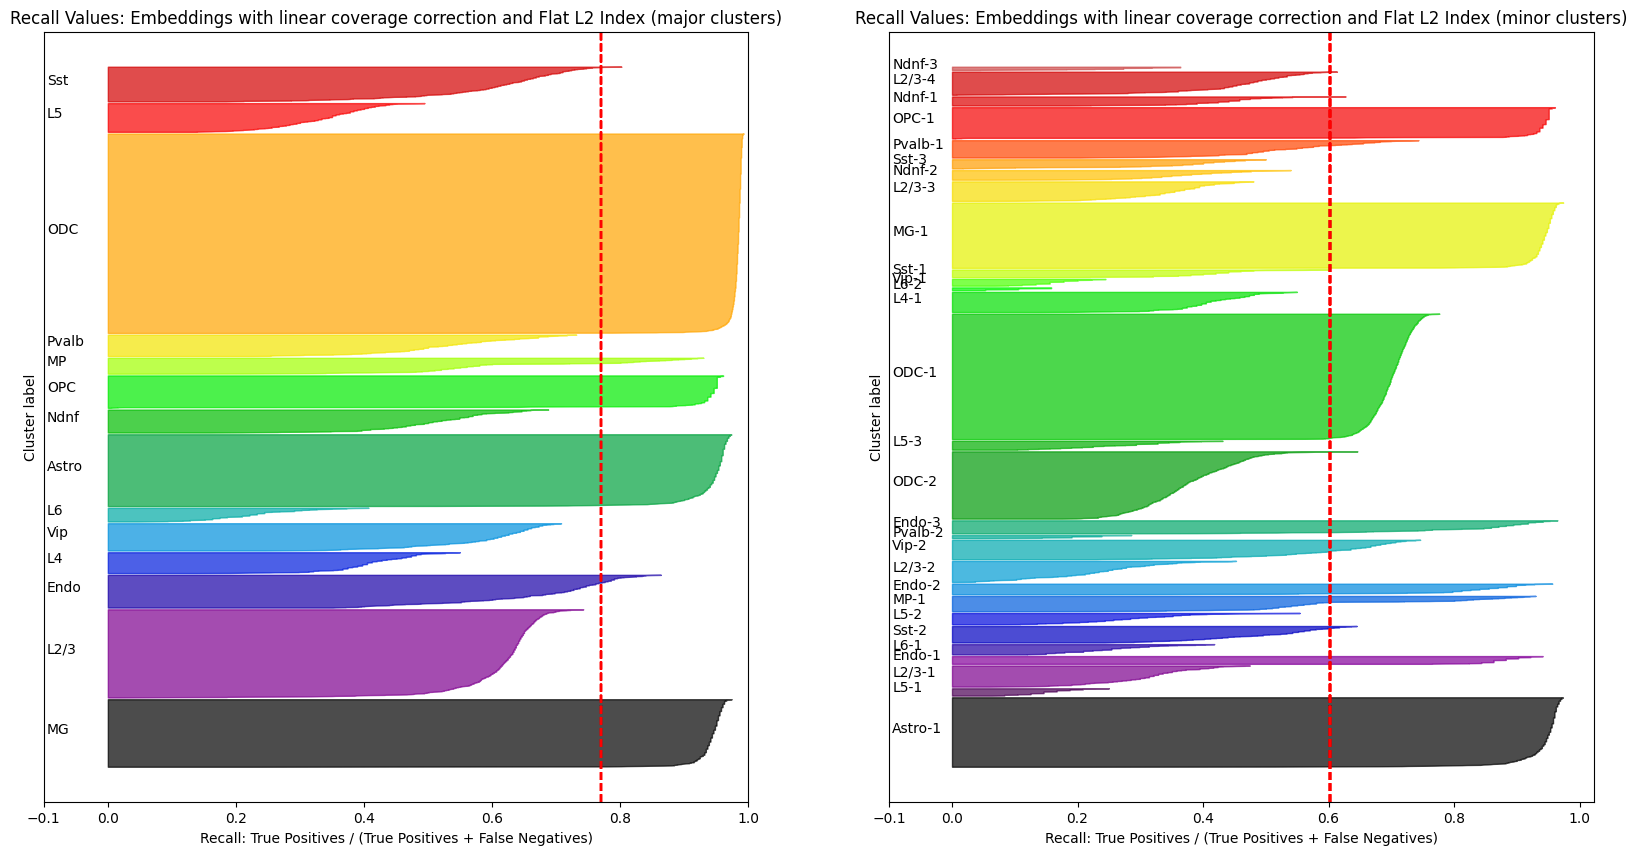

True
4238
Total search time: 2.202987 seconds
Index size: 1084973 bytes
Average recall: 0.78941
Average recall: 0.59743


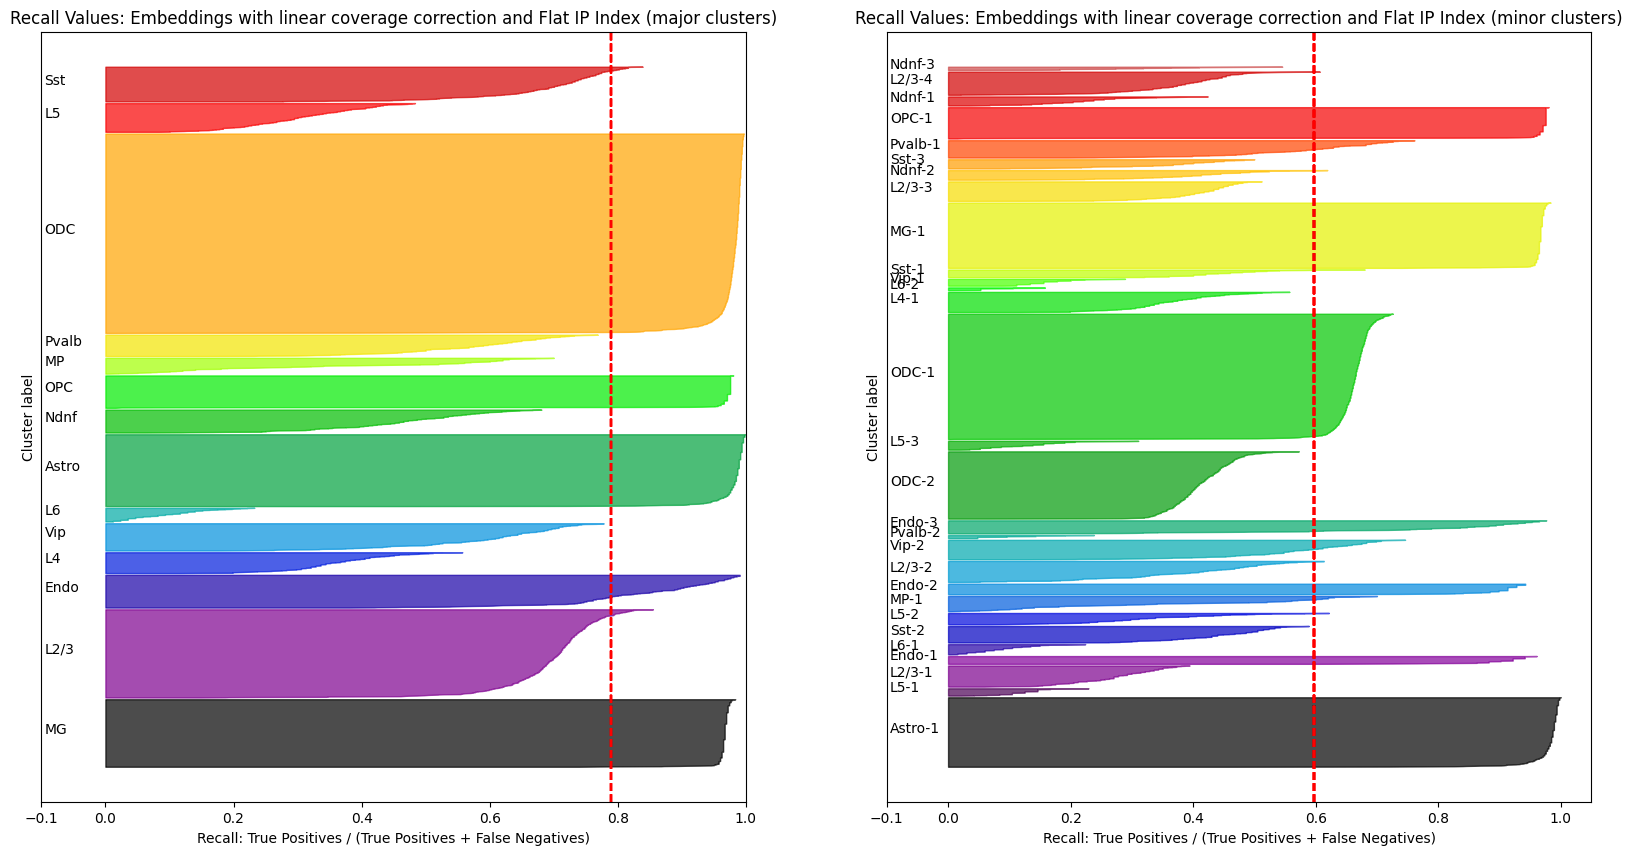

In [11]:
### EMBEDDINGS AFTER LINEAR CORRECTION OF COVERAGE
db = np.array(embedding64["embed_correct_coverage_fh"])

# L2 FLAT INDEX
# create index and search
res5 = baseline_index(db, faiss.IndexFlatL2(64))
# plot recall values
plot_recall(res5, "Recall Values: Embeddings with linear coverage correction and Flat L2 Index", "Baseline_FH_L2.png")

# IP FLAT INDEX
# create index and search
res6 = baseline_index(db, faiss.IndexFlatIP(64))
# plot recall values
plot_recall(res6, "Recall Values: Embeddings with linear coverage correction and Flat IP Index", "Baseline_FH_IP.png")

True
4238
Total search time: 2.335701 seconds
Index size: 1084973 bytes
Average recall: 0.79874
Average recall: 0.61960


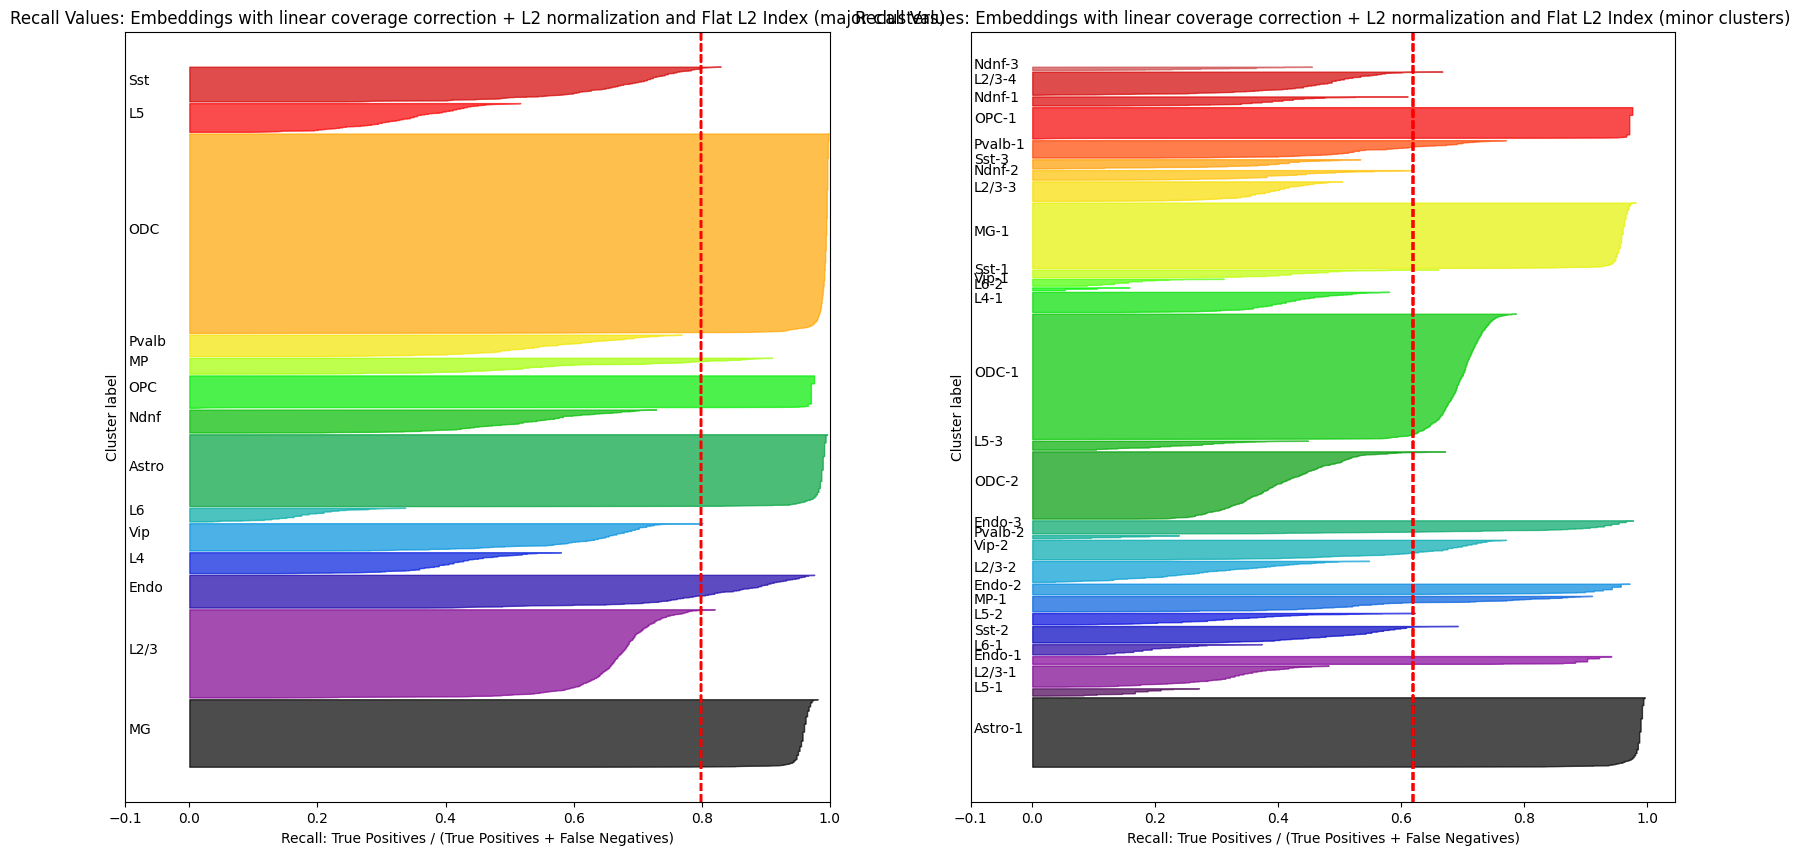

True
4238
Total search time: 2.527405 seconds
Index size: 1084973 bytes
Average recall: 0.79874
Average recall: 0.61960


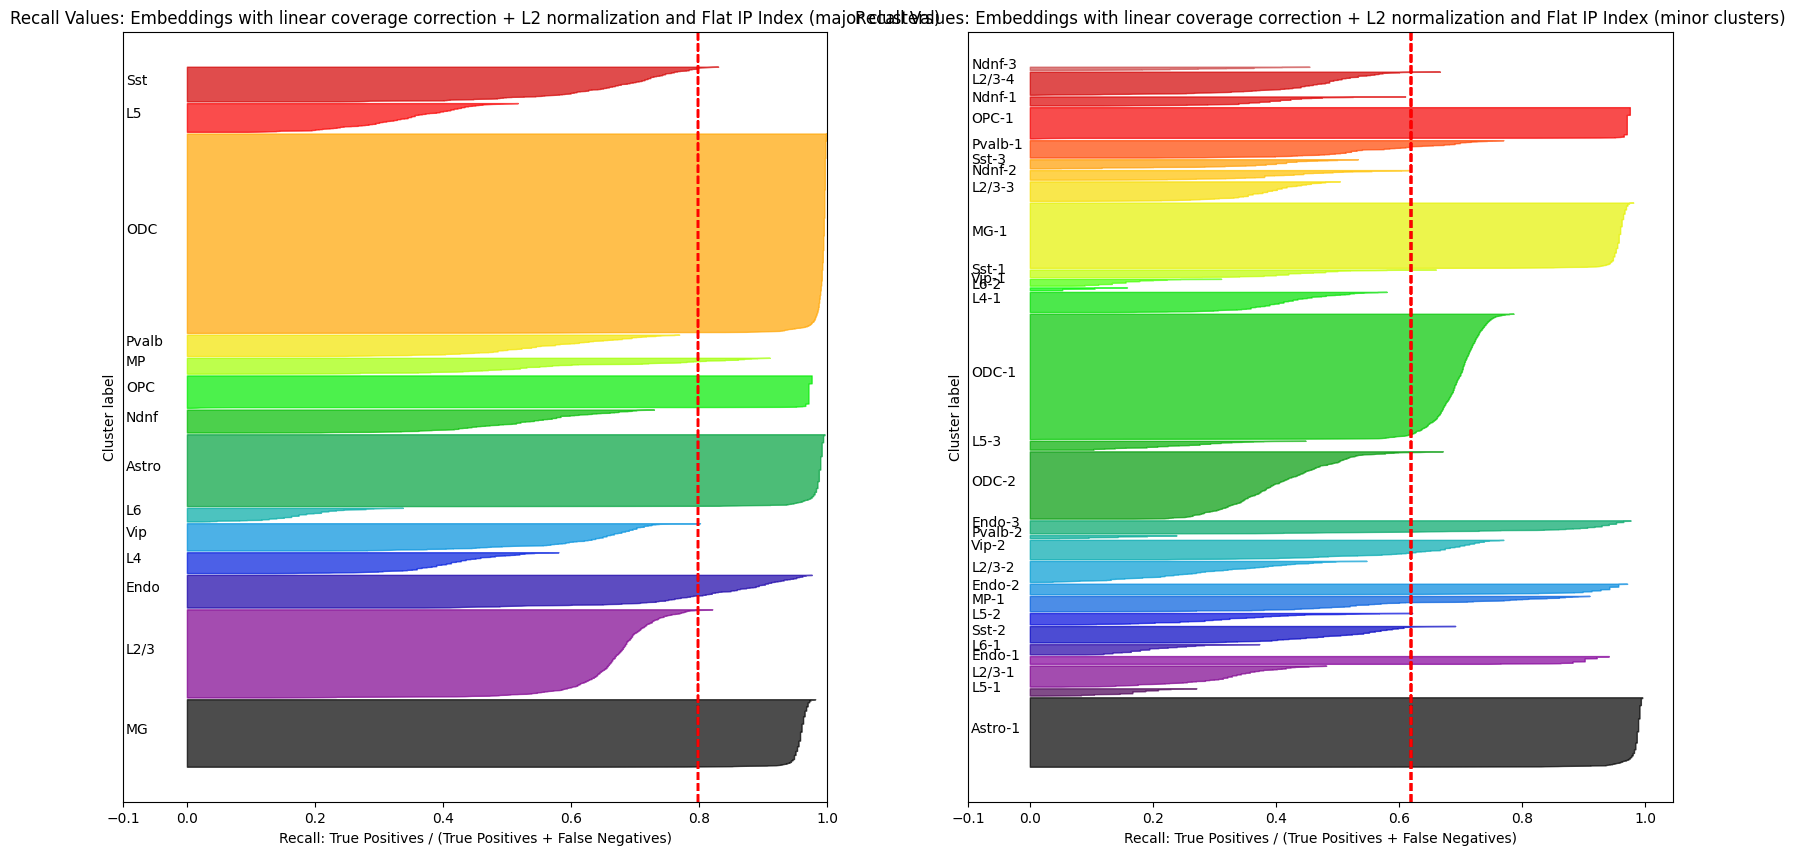

In [12]:
### EMBEDDINGS AFTER LINEAR CORRECTION OF COVERAGE + L2 NORMALIZATION
db = np.array(embedding64["embed_l2_norm_correct_coverage_fh"])

# L2 FLAT INDEX
# create index and search
res7 = baseline_index(db, faiss.IndexFlatL2(64))
# plot recall values
plot_recall(res7, "Recall Values: Embeddings with linear coverage correction + L2 normalization and Flat L2 Index", "Baseline_L2FH_L2.png")

# IP FLAT INDEX
# create index and search
res8 = baseline_index(db, faiss.IndexFlatIP(64))
# plot recall values
plot_recall(res8, "Recall Values: Embeddings with linear coverage correction + L2 normalization and Flat IP Index", "Baseline_L2FH_IP.png")

In [ ]:
#### now that we've selected the final baseline
#### rerun the index/search 4238 times to get averages for search time
#### also report the average recall for each cluster
db = np.array(embedding64["embed_l2_norm"])

# L2 FLAT INDEX
# create index and search
res1 = baseline_index(db, faiss.IndexFlatL2(64))
# plot recall values
plot_recall(res1, "Recall Values: L2 Normalized embedding and Flat L2 Index", "Baseline_L2Norm_L2.png")

In [52]:
def avg_baseline_search_time():
    search_times = []
    
    database = np.array(embedding64["embed_l2_norm"]) 
    d = 64
    k = len(database)
    index=faiss.IndexFlatL2(64)
    index.add(database)

    for i in range(4500):
        start = time.time()
        D, I = index.search(database, k)
        end = time.time()
        search_times.append((end-start))

    return search_times

# update plots to include more detail
def recall_subplot2(ax, labels, true_clusters, recall, embedname):
    y_lower = 10
    recall_avg = statistics.mean(recall)    
    print("Average recall: %.5f" % recall_avg)
    
    for i in range(len(labels)):           
        # select cells in cluster
        cluster_filter = [element==labels[i] for element in true_clusters]
        ith_cluster_recall_values = list(itertools.compress(recall,cluster_filter))
        ith_cluster_recall_values.sort()
        size_cluster_i = len(ith_cluster_recall_values)
        y_upper = y_lower + size_cluster_i

        # pick color
        color = cm.nipy_spectral(float(i) / len(labels))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_recall_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7,)

        # label the cluster
        lab = str(labels[i]) + " (" + str(round(statistics.mean(ith_cluster_recall_values),5)) + ")"
        ax.text(-0.215, y_lower + 0.5 * size_cluster_i, lab)
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(embedname)
        ax.set_xlabel("Recall: True Positives / (True Positives + False Negatives)")
        ax.set_ylabel("Cluster label (average recall)")

        # The vertical line for average recall score of all the values
        ax.axvline(x=recall_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])      
        
def plot_recall2(search_result, title, filename):
    # get recall
    recall_major, recall_minor = get_recall(search_result)
     
    # set up plot for figure 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20, 10)
    ax1.set_xlim([-0.23, 1])
    ax2.set_xlim([-0.23, 1])
    

    recall_subplot2(ax1, major_labels, label_info['cluster label'], recall_major, str(title+" (major clusters)"))
    recall_subplot2(ax2, minor_labels, label_info['cluster label minor'], recall_minor, str(title+" (minor clusters)"))  

    avg1 = statistics.mean(recall_major)
    avg2 = statistics.mean(recall_minor)
    ax1.text((avg1-.4), 4475, "Overall average: " + str(round(avg1,5)), color="red")
    ax2.text((avg2-.4), 4600, "Overall average: " + str(round(avg2,5)), color="red")

    fig.savefig(filename)
    plt.show()

In [57]:
# search_times = avg_baseline_search_time()
# print("Average search time: %.6f seconds" % (statistics.mean(search_times)))

Average recall: 0.79842
Average recall: 0.62159


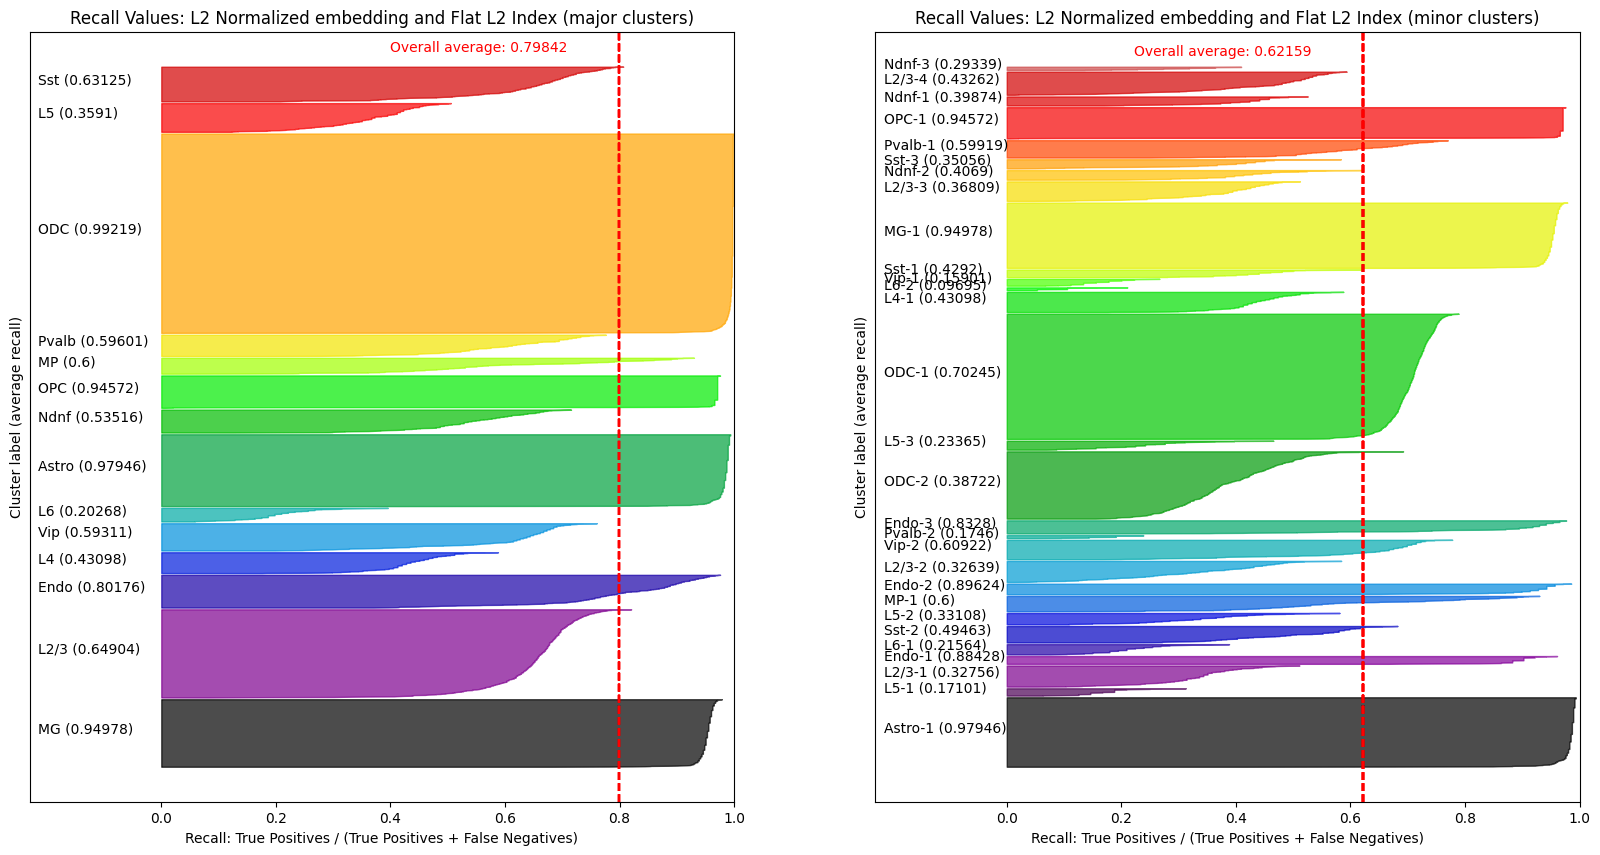

In [58]:
plot_recall2(res1, "Recall Values: L2 Normalized embedding and Flat L2 Index", "Baseline_final.png")